In [2]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Global visualization setup for publication-quality figures.
Defines color palette, style settings, and shared helper functions.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from pathlib import Path


# ============================================================================
# Style Configuration
# ============================================================================

# Accessible, high-contrast palette
PALETTE = {
    'baseline':   '#E29578',  # Coral (FCI/Exact/Reference)
    'primary':    '#264653',  # Charcoal (Main Method/Variational)
    'secondary':  '#2A9D8F',  # Teal (Optimization/sCI)
    'accent':     '#457B9D',  # Slate Blue (Auxiliary/Chem Acc)
    'bar_fill':   '#E9ECEF',  # Light Gray (Background bars)
    'bar_edge':   '#6C757D',  # Slate Gray (Bar outlines)
    'grid':       '#E5E5E5',  # Subtle Grid
    'text':       '#333333'   # Dark Gray Text
}

def set_publication_style():
    """Apply global matplotlib settings for clean, academic aesthetics."""
    rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 11,
        'axes.linewidth': 1.2,
        'axes.edgecolor': PALETTE['text'],
        'axes.labelcolor': PALETTE['text'],
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.color': PALETTE['text'],
        'ytick.color': PALETTE['text'],
        'text.color': PALETTE['text'],
        'figure.dpi': 300,
        'grid.color': PALETTE['grid'],
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
        'legend.frameon': False,
        'legend.fontsize': 10,
    })

def format_axis(ax, xlabel=None, ylabel=None, grid=True, log_scale=False):
    """Standardize axis labels, grids, and tick formatting."""
    if xlabel: 
        ax.set_xlabel(xlabel, labelpad=8, fontweight='medium')
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=8, fontweight='medium')
    
    if grid:
        ax.grid(True, zorder=0)

    # Clean formatting for log scales vs linear
    if log_scale:
        ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
    else:
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# Initialize style immediately
set_publication_style()

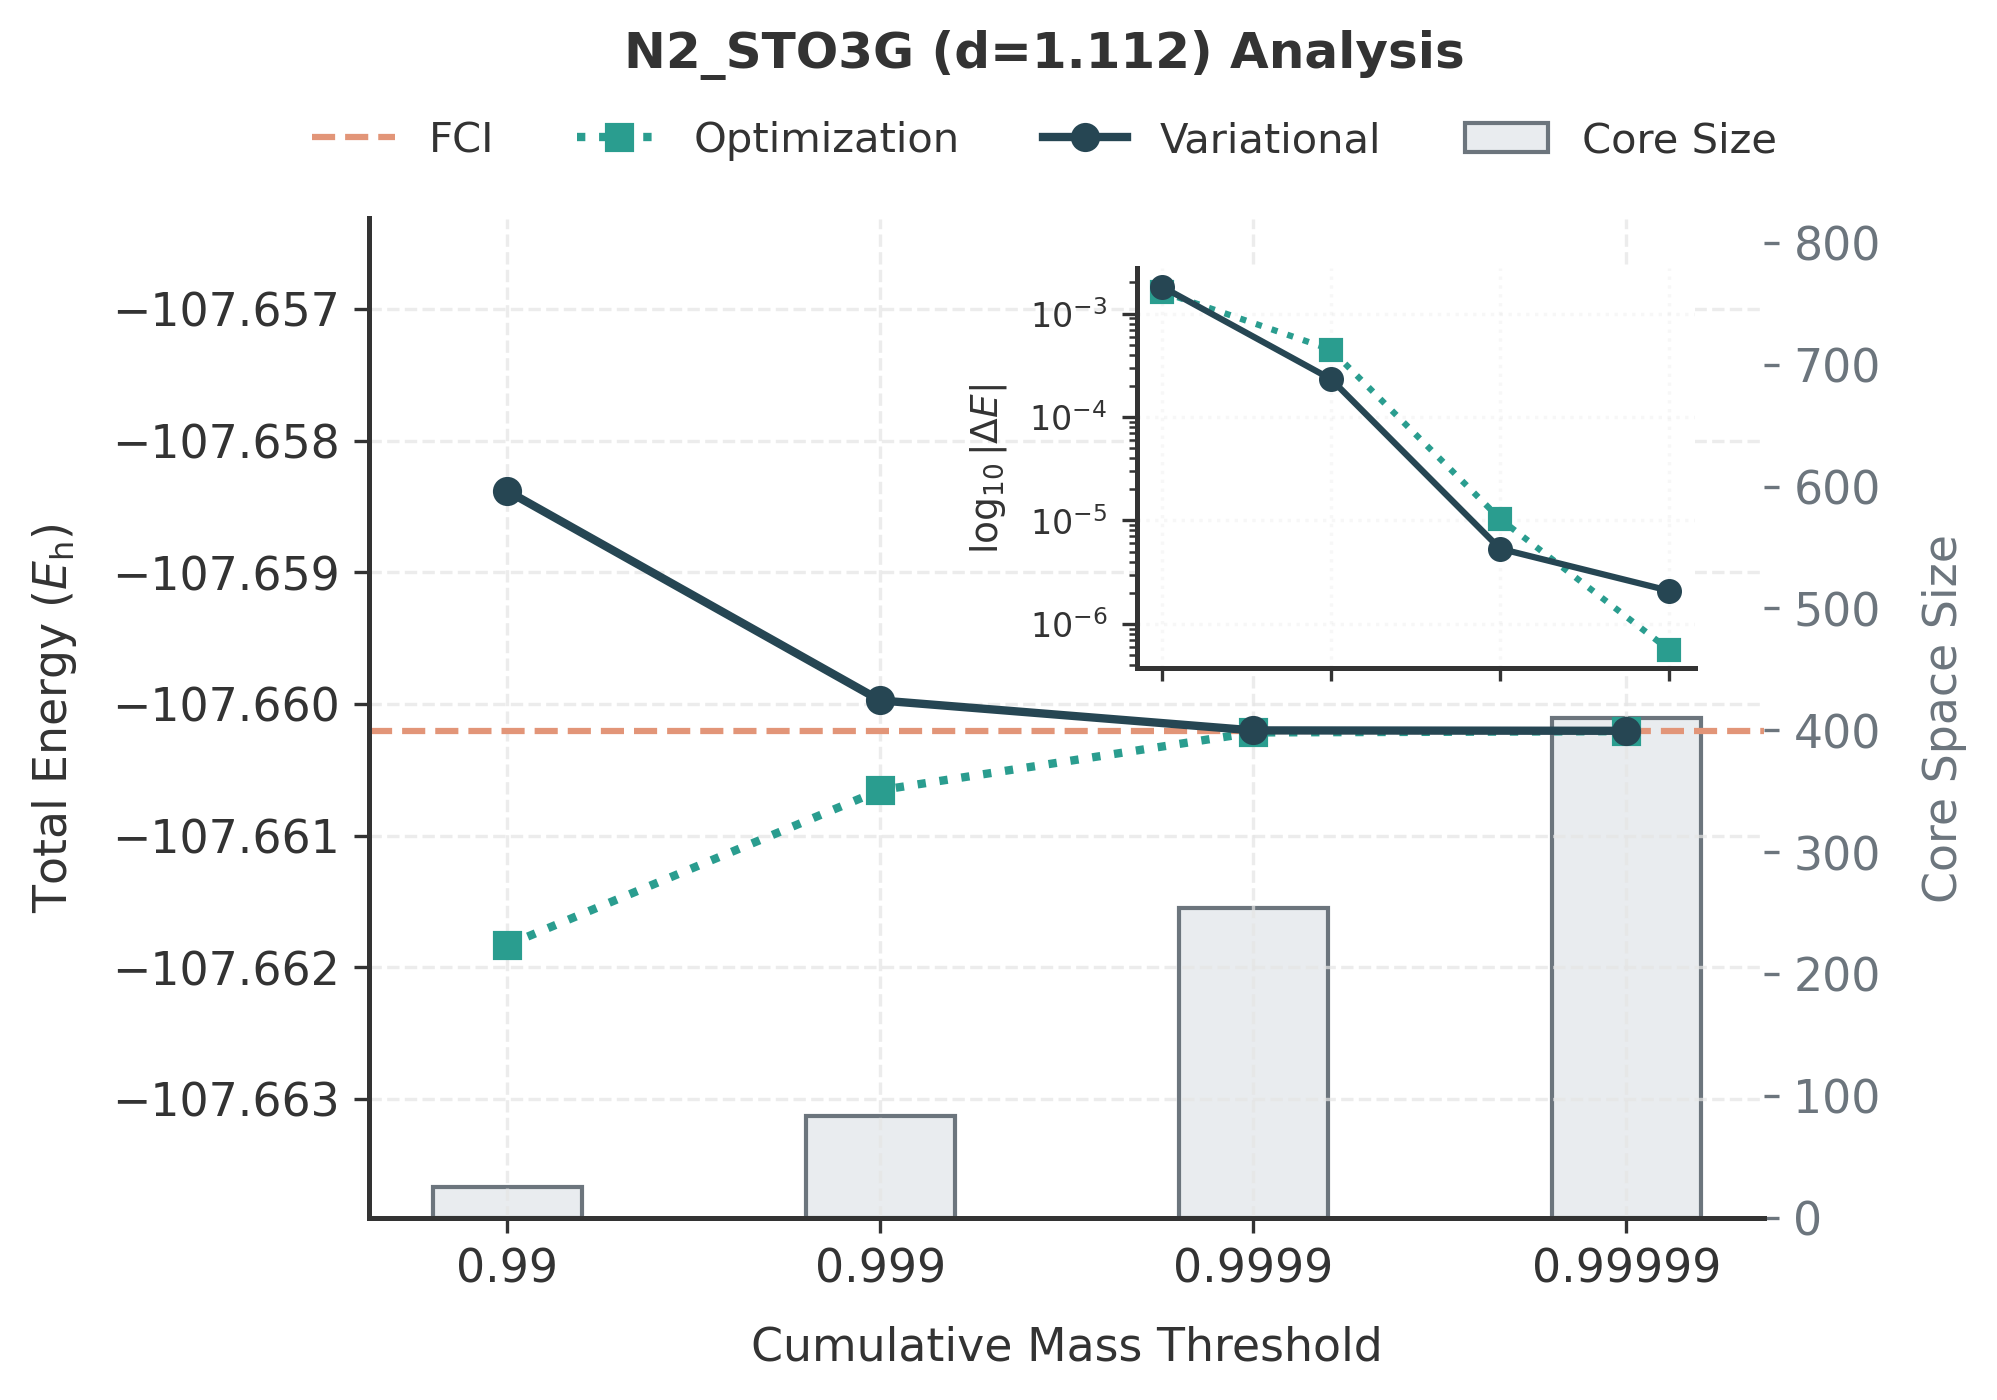

In [3]:
def plot_n2_convergence():
    # Data setup
    E_FCI = -107.66020642
    mass = ["0.99", "0.999", "0.9999", "0.99999"]
    E_opt = np.array([-107.66183127, -107.66065496, -107.66021676, -107.66020698])
    E_var = np.array([-107.65838276, -107.65997371, -107.66020109, -107.66020433])
    core_size = [25, 83, 254, 410]
    x = np.arange(len(mass))

    # Main figure
    fig, ax1 = plt.subplots(figsize=(6, 4.5))
    plt.subplots_adjust(top=0.85)

    # Core size bars (right axis)
    ax2 = ax1.twinx()
    ax2.bar(x, core_size, color=PALETTE['bar_fill'], edgecolor=PALETTE['bar_edge'], 
            width=0.4, zorder=0, label="Core Size")
    ax2.set_ylabel("Core Space Size", color=PALETTE['bar_edge'], labelpad=10)
    ax2.tick_params(axis='y', colors=PALETTE['bar_edge'])
    ax2.spines['right'].set_color(PALETTE['bar_edge'])
    ax2.set_ylim(0, max(core_size) * 2)

    # Energy curves (left axis, foreground)
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)
    
    l1 = ax1.axhline(E_FCI, color=PALETTE['baseline'], linestyle='--', linewidth=1.5, label="FCI")
    l2, = ax1.plot(x, E_opt, 's:', color=PALETTE['secondary'], markersize=6, linewidth=2, label="Optimization")
    l3, = ax1.plot(x, E_var, 'o-', color=PALETTE['primary'], markersize=6, linewidth=2, label="Variational")
    
    format_axis(ax1, "Cumulative Mass Threshold", r"Total Energy ($E_{\mathrm{h}}$)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(mass)
    
    # Auto-scale y-axis with margin
    all_E = np.concatenate([E_opt, E_var])
    margin = (all_E.max() - all_E.min()) * 0.6
    ax1.set_ylim(all_E.min() - margin, all_E.max() + margin)

    # Inset: log-scale energy errors
    inset = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
    inset.semilogy(x, np.abs(E_opt - E_FCI), 's:', color=PALETTE['secondary'], markersize=5, linewidth=1.5)
    inset.semilogy(x, np.abs(E_var - E_FCI), 'o-', color=PALETTE['primary'], markersize=5, linewidth=1.5)
    inset.set_ylabel(r"$\log_{10}|\Delta E|$", fontsize=9, labelpad=5)
    inset.tick_params(axis='x', labelbottom=False, length=3)
    inset.tick_params(axis='y', labelsize=8)
    inset.grid(True, alpha=0.3, linestyle=':')

    # Legend and title
    fig.legend([l1, l2, l3, ax2.patches[0]], ["FCI", "Optimization", "Variational", "Core Size"],
               loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
    fig.suptitle(r"N2_STO3G (d=1.112) Analysis", y=0.99, fontsize=12, weight='bold')
    
    plt.show()

plot_n2_convergence()


Computing FCI ref (14400 dets)...
k=10: sCI=-130.9281, Lowdin=-130.9742
k=50: sCI=-130.9700, Lowdin=-130.9786
k=100: sCI=-130.9763, Lowdin=-130.9782
k=150: sCI=-130.9776, Lowdin=-130.9782
k=200: sCI=-130.9780, Lowdin=-130.9783
k=400: sCI=-130.9782, Lowdin=-130.9783


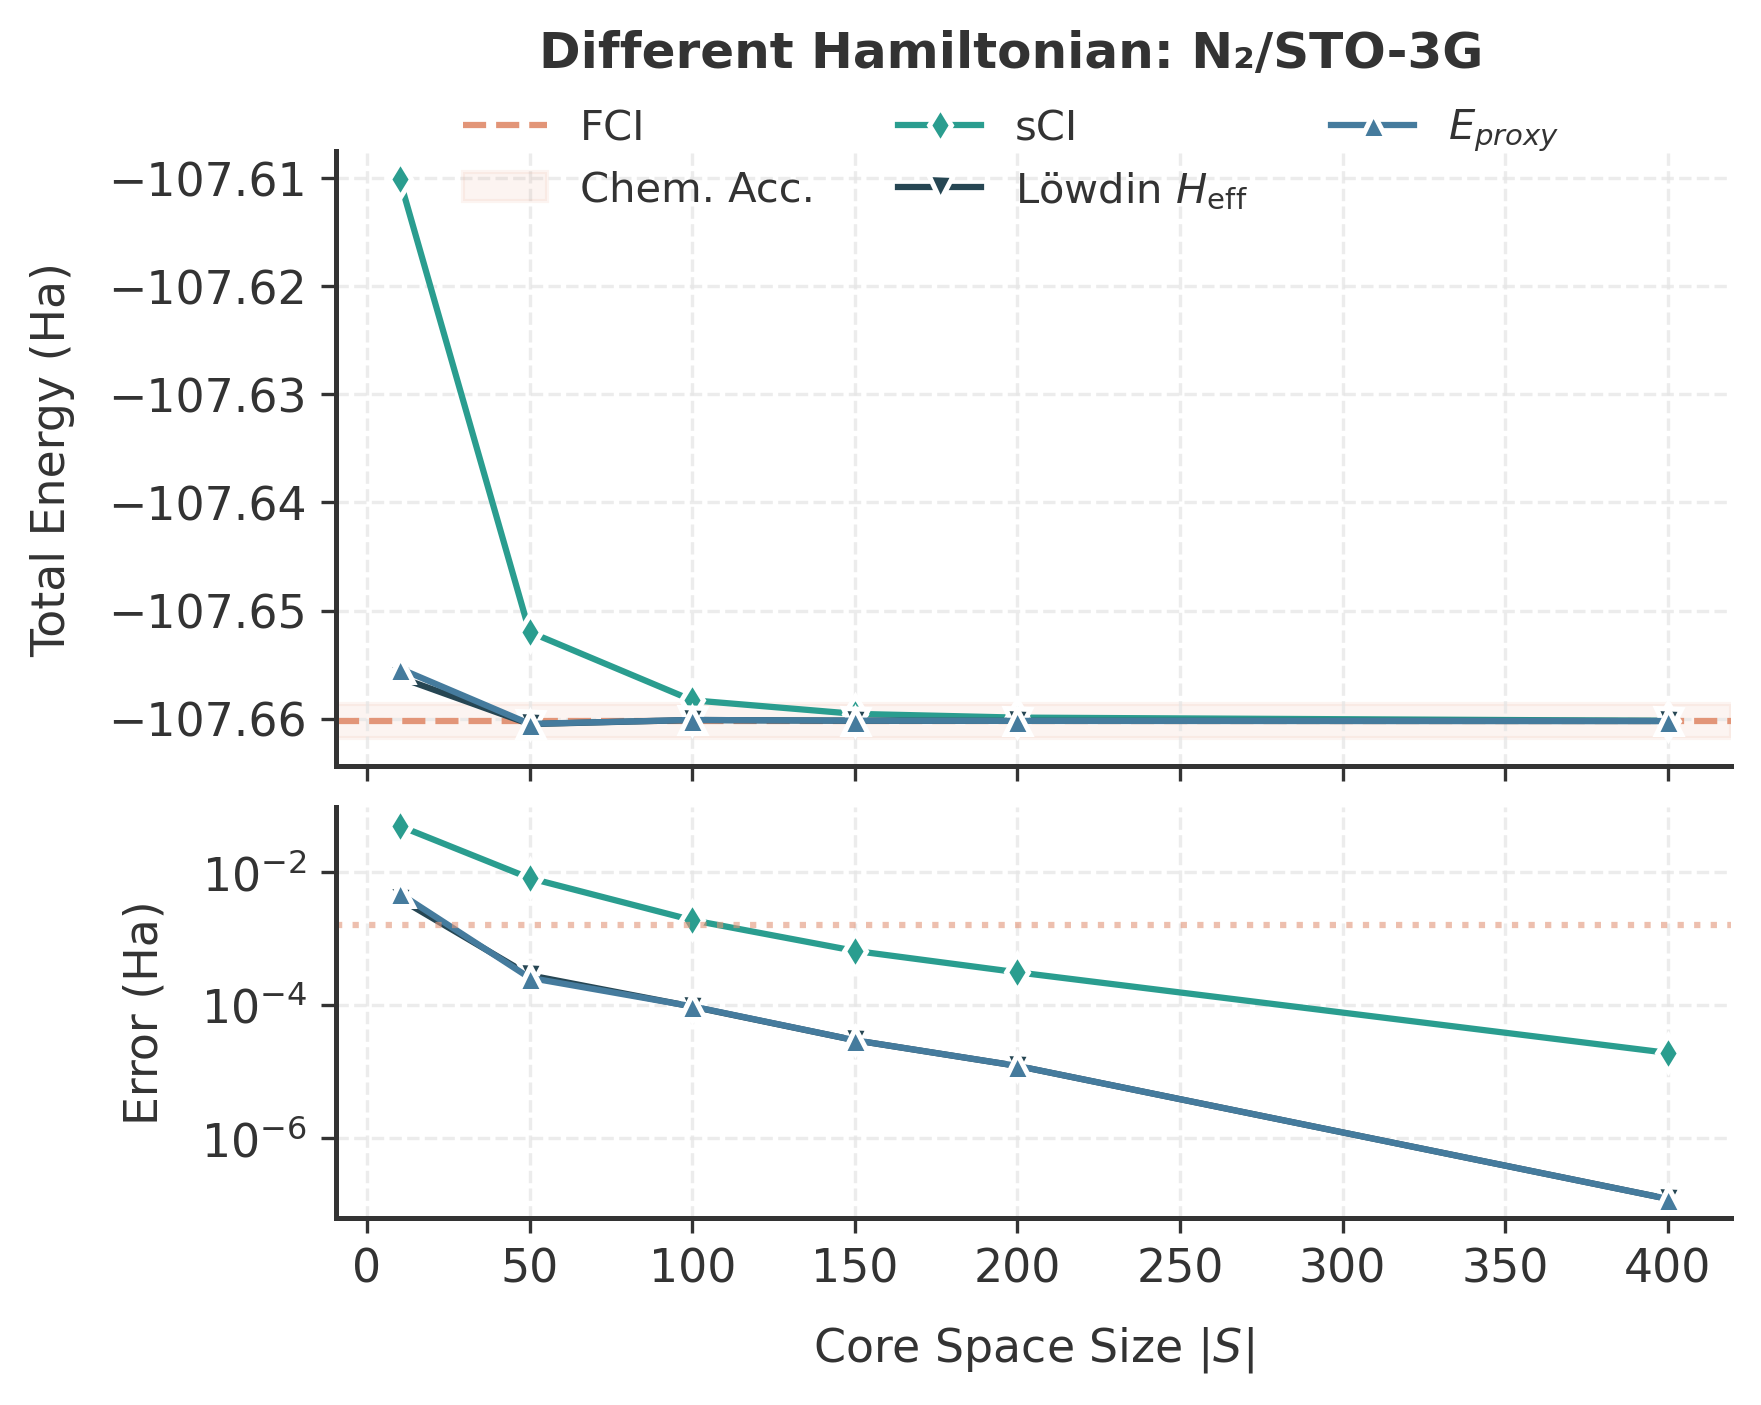

In [13]:
"""
Experiment 2: Löwdin Effective Hamiltonian.
Compares convergence of sCI, Löwdin Perturbation, and Exact Variational methods.
"""

from dataclasses import dataclass, field
from pathlib import Path
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import lever

# Simulation Config
CFG = {
    "sys_name": "N₂/STO-3G",
    "path": Path("/home/wsmxcz/LEVER/examples/runs/20251203_224550_N2_sto3g_1.112/hamiltonian.fcidump"),
    "n_orb": 10, "n_elec": (7, 7),
    "k_steps": [10, 50, 100, 150, 200, 400],
    "eps": 1e-12
}

@dataclass
class StudyResults:
    k: list[int] = field(default_factory=list)
    E_sCI: list[float] = field(default_factory=list)
    E_Lowdin: list[float] = field(default_factory=list)
    E_Exact: list[float] = field(default_factory=list)

def solve_eigen(H):
    """Solver wrapper for dense/sparse matrices."""
    if H.shape[0] < 10:
        evals, evecs = np.linalg.eigh(H.toarray())
    else:
        evals, evecs = spla.eigsh(H, k=1, which="SA", tol=1e-15)
    return evals[0], evecs[:, 0]

def run_simulation():
    """Run convergence study (sCI vs Lowdin vs Exact)."""
    if not CFG['path'].exists(): raise FileNotFoundError("FCIDUMP missing.")
    
    # Setup System
    int_ctx = lever.IntCtx(str(CFG['path']), CFG['n_orb'])
    fci_dets = lever.gen_fci_dets(CFG['n_orb'], *CFG['n_elec'])
    E_nuc = int_ctx.get_e_nuc()
    
    # Compute FCI Reference
    print(f"Computing FCI ref ({len(fci_dets)} dets)...")
    ham_fci, _ = lever.engine.hamiltonian.get_ham_ss(fci_dets, int_ctx, CFG['n_orb'])
    E_fci, psi_fci = solve_eigen(sp.coo_matrix((ham_fci.vals, (ham_fci.rows, ham_fci.cols)), shape=ham_fci.shape).tocsr())
    
    # Sort determinants by weight
    ranking = np.argsort(-np.abs(psi_fci))
    results = StudyResults()
    
    # Loop over model space sizes
    for k in [k for k in CFG['k_steps'] if k <= len(fci_dets)]:
        S_dets = fci_dets[ranking[:k]]
        ham_ss, ham_sc, space = lever.get_ham_proxy(S_dets, int_ctx, CFG['n_orb'], mode="none")
        
        # 1. sCI
        H_ss_csr = sp.coo_matrix((ham_ss.vals, (ham_ss.rows, ham_ss.cols)), shape=ham_ss.shape).tocsr()
        E_sCI, _ = solve_eigen(H_ss_csr)
        
        # 2. Lowdin
        ham_eff = lever.engine.hamiltonian.get_ham_eff(ham_ss, ham_sc, space.h_diag_c, E_sCI, "sigma", CFG['eps'], True)
        H_eff_csr = sp.coo_matrix((ham_eff.vals, (ham_eff.rows, ham_eff.cols)), shape=ham_eff.shape).tocsr()
        E_Lowdin, _ = solve_eigen(H_eff_csr)
        
        # 3. Exact T-space
        H_sc_csr = sp.coo_matrix((ham_sc.vals, (ham_sc.rows, ham_sc.cols)), shape=ham_sc.shape).tocsr()
        H_tilde = sp.bmat([[H_ss_csr, H_sc_csr], [H_sc_csr.T.conj(), sp.diags(space.h_diag_c)]], format="csr")
        E_exact, psi_tilde = solve_eigen(H_tilde)
    
        results.E_sCI.append(E_sCI + E_nuc)
        results.E_Lowdin.append(E_Lowdin + E_nuc)
        results.E_Exact.append(E_exact + E_nuc)
        results.k.append(k)
        print(f"k={k}: sCI={E_sCI:.4f}, Lowdin={E_Lowdin:.4f}")

    return results, E_fci + E_nuc

def plot_study(res, e_fci):
    """Generate dual-panel convergence plot."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, height_ratios=[3, 2])
    plt.subplots_adjust(top=0.9, hspace=0.08)
    
    style = {'markersize': 6, 'linewidth': 1.5, 'markeredgecolor': 'white', 'markeredgewidth': 1.2}
    
    # Panel 1: Absolute Energies
    ax1.axhspan(e_fci - 1.6e-3, e_fci + 1.6e-3, color=PALETTE['baseline'], alpha=0.1, label="Chem. Acc.")
    ax1.axhline(e_fci, color=PALETTE['baseline'], linestyle='--', label="FCI")
    
    ax1.plot(res.k, res.E_sCI, marker='d', color=PALETTE['secondary'], label="sCI", **style)
    ax1.plot(res.k, res.E_Lowdin, marker='v', color=PALETTE['primary'], label=r"Löwdin $H_{\mathrm{eff}}$", **style)
    ax1.plot(res.k, res.E_Exact, marker='^', color=PALETTE['accent'], label=r"$E_{proxy}$", **style)
    format_axis(ax1, ylabel="Total Energy (Ha)")
    
    # Panel 2: Log Errors
    for y, c, m in [(res.E_sCI, PALETTE['secondary'], 'd'), 
                    (res.E_Lowdin, PALETTE['primary'], 'v'), 
                    (res.E_Exact, PALETTE['accent'], '^')]:
        ax2.semilogy(res.k, np.abs(np.array(y) - e_fci), marker=m, color=c, **style)
        
    ax2.axhline(1.6e-3, color=PALETTE['baseline'], linestyle=':', alpha=0.6)
    format_axis(ax2, xlabel=r"Core Space Size $|S|$", ylabel="Error (Ha)", log_scale=True)
    
    # Legend & Title
    h, l = ax1.get_legend_handles_labels()
    order = [1, 0, 2, 3, 4] # Reorder for clarity
    fig.legend([h[i] for i in order], [l[i] for i in order], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
    fig.suptitle(f"Different Hamiltonian: {CFG['sys_name']}", y=0.99, fontsize=12, weight='bold')
    plt.show()

# Run
if __name__ == "__main__":
    results, e_ref = run_simulation()
    plot_study(results, e_ref)

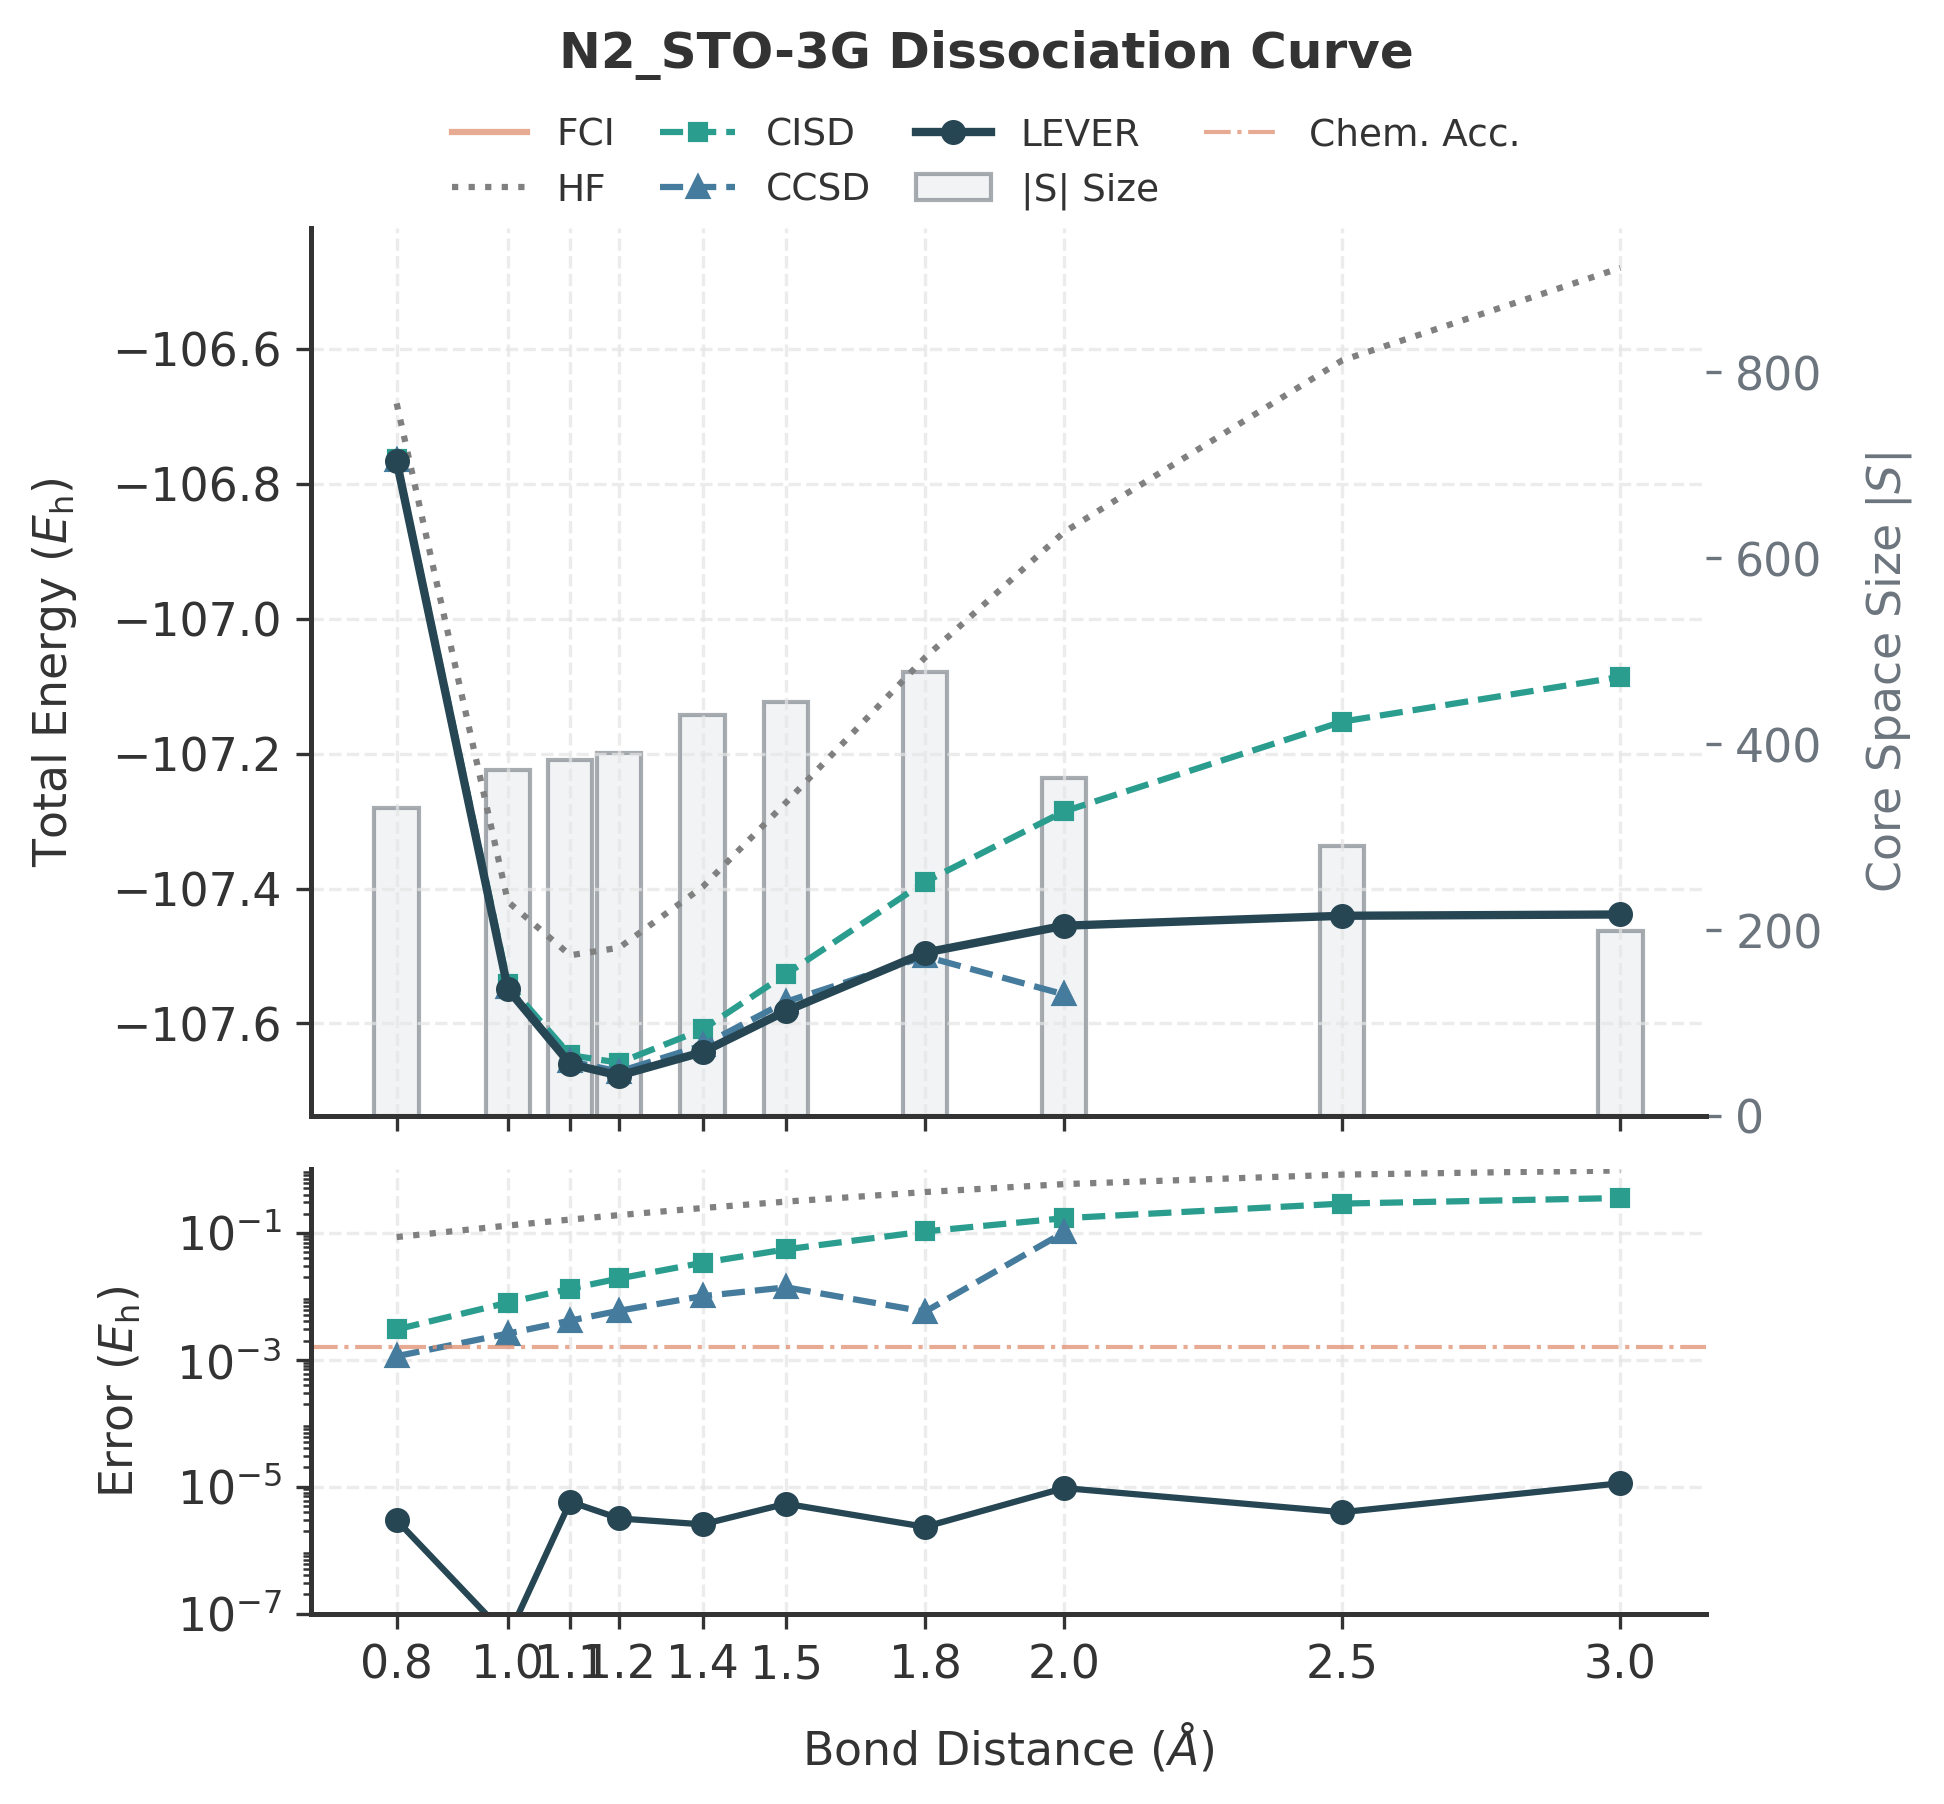

In [5]:
"""
Experiment 3: N2 Bond Dissociation PES.
Panel 1: Absolute energies and Model Space Size.
Panel 2: Log-scale error relative to FCI baseline.
"""
CSV_PATH = Path("scans/N2_sto3g/scan_results.csv")

def plot_pes_scan(csv_path: Path):
    if not csv_path.exists():
        print(f"Skipping PES plot: {csv_path} not found.")
        return
    
    df = pd.read_csv(csv_path).sort_values("dist")
    
    # Filter CCSD: only keep data where dist <= 2.0
    df_ccsd = df[df['dist'] <= 2.0].copy()
    
    # Create figure with 2 panels
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, 
                                   gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=0.08, top=0.88)
    
    # --- Panel 1: Energy curves with model space size bars ---
    
    # Right axis: model space size bars
    ax1_r = ax1.twinx()
    bars = ax1_r.bar(df['dist'], df['n_s'], color=PALETTE['bar_fill'], 
                     edgecolor=PALETTE['bar_edge'], width=0.08, 
                     label="|S| Size", zorder=0, alpha=0.6)
    ax1_r.set_ylabel("Core Space Size $|S|$", color=PALETTE['bar_edge'], labelpad=10)
    ax1_r.tick_params(axis='y', colors=PALETTE['bar_edge'])
    ax1_r.spines['right'].set_color(PALETTE['bar_edge'])
    ax1_r.set_ylim(0, df['n_s'].max() * 2.0)
    
    # Left axis: energy curves (plotted on top)
    ax1.set_zorder(ax1_r.get_zorder() + 1)
    ax1.patch.set_visible(False)
    
    l_fci, = ax1.plot(df['dist'], df['E_FCI'], color=PALETTE['baseline'], 
                      alpha=0.8, linestyle='-', linewidth=1.5, label="FCI (Ref)")
    l_hf, = ax1.plot(df['dist'], df['E_HF'], color='gray', linestyle=':', 
                     linewidth=1.5, label="HF")
    l_cisd, = ax1.plot(df['dist'], df['E_CISD'], PALETTE['secondary'], 
                       marker='s', markersize=4, linestyle='--', label="CISD")
    l_ccsd, = ax1.plot(df_ccsd['dist'], df_ccsd['E_CCSD'], color=PALETTE['accent'], 
                       marker='^', markersize=5, linestyle='--', label="CCSD")
    l_lev, = ax1.plot(df['dist'], df['E_LEVER'], color=PALETTE['primary'], 
                      marker='o', markersize=5, linestyle='-', linewidth=2, label="LEVER")
    
    format_axis(ax1, ylabel=r"Total Energy ($E_{\mathrm{h}}$)")
    
    # --- Panel 2: Log-scale errors ---
    
    err_hf = np.abs(df['E_HF'] - df['E_FCI'])
    err_cisd = np.abs(df['E_CISD'] - df['E_FCI'])
    err_ccsd = np.abs(df_ccsd['E_CCSD'] - df_ccsd['E_FCI'])
    err_lev = np.abs(df['E_LEVER'] - df['E_FCI'])
    
    ax2.semilogy(df['dist'], err_hf, color='gray', linestyle=':', linewidth=1.5)
    ax2.semilogy(df['dist'], err_cisd, color=PALETTE['secondary'], marker='s', markersize=4, linestyle='--')
    ax2.semilogy(df_ccsd['dist'], err_ccsd, color=PALETTE['accent'], 
                 marker='^', markersize=5, linestyle='--')
    ax2.semilogy(df['dist'], err_lev, color=PALETTE['primary'], 
                 marker='o', markersize=5, linestyle='-')
    
    l_chem = ax2.axhline(1.6e-3, color=PALETTE['baseline'], linestyle='-.', 
                         linewidth=1, alpha=0.8, label="Chem. Acc.")
    
    # Finer log scale labels
    ax2.set_ylim(1e-7, 1e0)
    ax2.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=7))
    ax2.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=20))
    
    format_axis(ax2, xlabel=r"Bond Distance ($\AA$)", ylabel=r"Error ($E_{\mathrm{h}}$)", log_scale=True)
    ax2.set_xticks(df['dist'])
    ax2.set_xticklabels([f"{x:.1f}" for x in df['dist']])
    
    # --- Legend ---
    handles = [l_fci, l_hf, l_cisd, l_ccsd, l_lev, bars, l_chem]
    labels = ["FCI", "HF", "CISD", "CCSD", "LEVER", "|S| Size", "Chem. Acc."]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), 
               ncol=4, columnspacing=1.2, fontsize=9)
    
    fig.suptitle(r"N2_STO-3G Dissociation Curve", y=0.99, fontsize=12, weight='bold')
    plt.show()

plot_pes_scan(CSV_PATH)

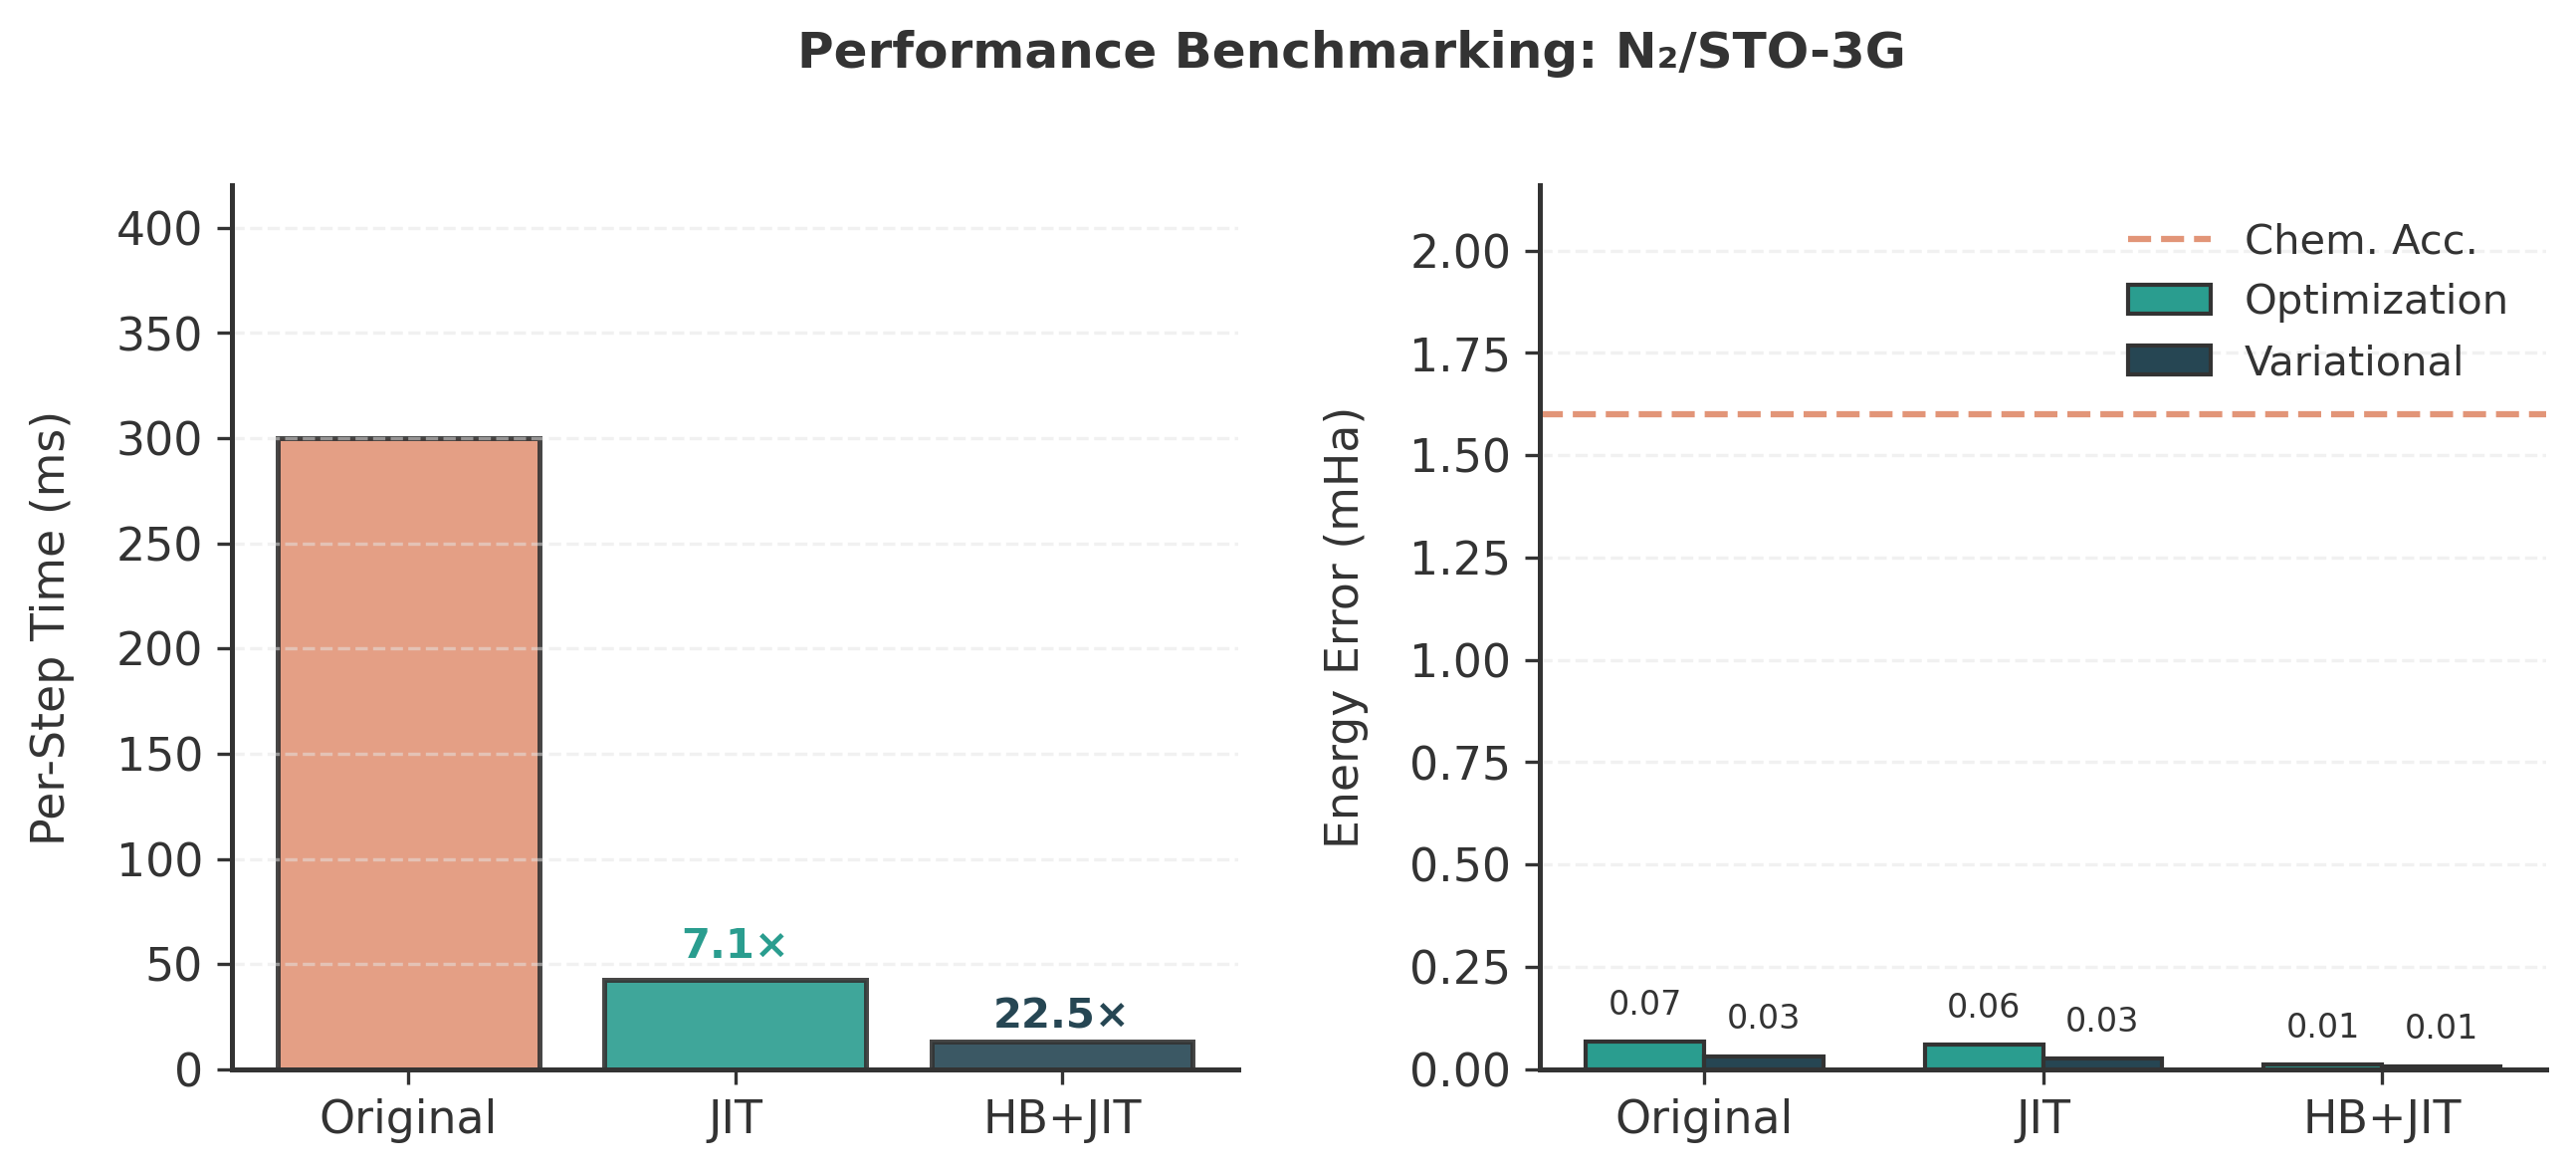

In [6]:
"""
Experiment 4: Performance Optimization.
Panel 1: Runtime speedup.
Panel 2: Energy accuracy relative to FCI.
"""

def plot_performance():
    # Benchmark Data (Mass=0.999)
    data = {
        "Method": ["Original", "JIT", "HB+JIT"],
        "Time": [0.30024, 0.04249, 0.01335], # Seconds
        "E_Opt": [-107.6601395, -107.6601468, -107.660218],
        "E_Var": [-107.6601746, -107.6601811, -107.6601988],
        "E_FCI": -107.6602064
    }
    df = pd.DataFrame(data)
    speedup = df["Time"].iloc[0] / df["Time"]
    
    # Setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(top=0.85, wspace=0.3)
    x = np.arange(len(df))
    
    # --- Panel 1: Runtime (ms) ---
    # Colors represent optimization level
    colors = [PALETTE['baseline'], PALETTE['secondary'], PALETTE['primary']]
    bars = ax1.bar(x, df["Time"]*1000, color=colors, edgecolor=PALETTE['text'], 
                   linewidth=1.2, alpha=0.9, label="Time (ms)")
    
    # Annotate Speedup
    for i, (bar, sp) in enumerate(zip(bars, speedup)):
        if i > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.15, 
                     f'{sp:.1f}×', ha='center', va='bottom', 
                     fontsize=10, weight='bold', color=colors[i])

    ax1.set_ylabel("Per-Step Time (ms)", fontweight='medium', labelpad=10)
    ax1.set_ylim(0, df["Time"].max()*1000 * 1.4)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df["Method"])
    ax1.grid(True, axis='y', alpha=0.5, zorder=0)

    # --- Panel 2: Accuracy (mHa) ---
    E_fci = df["E_FCI"].iloc[0]
    err_opt = np.abs(df["E_Opt"] - E_fci) * 1000
    err_var = np.abs(df["E_Var"] - E_fci) * 1000
    
    w = 0.35
    b1 = ax2.bar(x - w/2, err_opt, w, color=PALETTE['secondary'], edgecolor=PALETTE['text'], label="Optimization")
    b2 = ax2.bar(x + w/2, err_var, w, color=PALETTE['primary'], edgecolor=PALETTE['text'], label="Variational")
    
    # Chemical Accuracy Line (Baseline Color)
    ax2.axhline(1.6, color=PALETTE['baseline'], linestyle='--', linewidth=1.5, label="Chem. Acc.", zorder=1)
    
    ax2.set_ylabel("Energy Error (mHa)", fontweight='medium', labelpad=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df["Method"])
    ax2.legend(loc='upper right', framealpha=0.95)
    ax2.grid(True, axis='y', alpha=0.5, zorder=0)
    ax2.set_ylim(0, max(err_opt.max(), 1.6) * 1.35)

    # Annotate values
    for group in [b1, b2]:
        for b in group:
            ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05, 
                     f'{b.get_height():.2f}', ha='center', va='bottom', fontsize=8)

    fig.suptitle("Performance Benchmarking: N₂/STO-3G", fontsize=12, weight='bold', y=0.98)
    plt.show()

plot_performance()

converged SCF energy = -106.479842622837


/tmp/ipykernel_144620/2658239450.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  coeffs_normalized = coeffs / np.linalg.norm(coeffs)


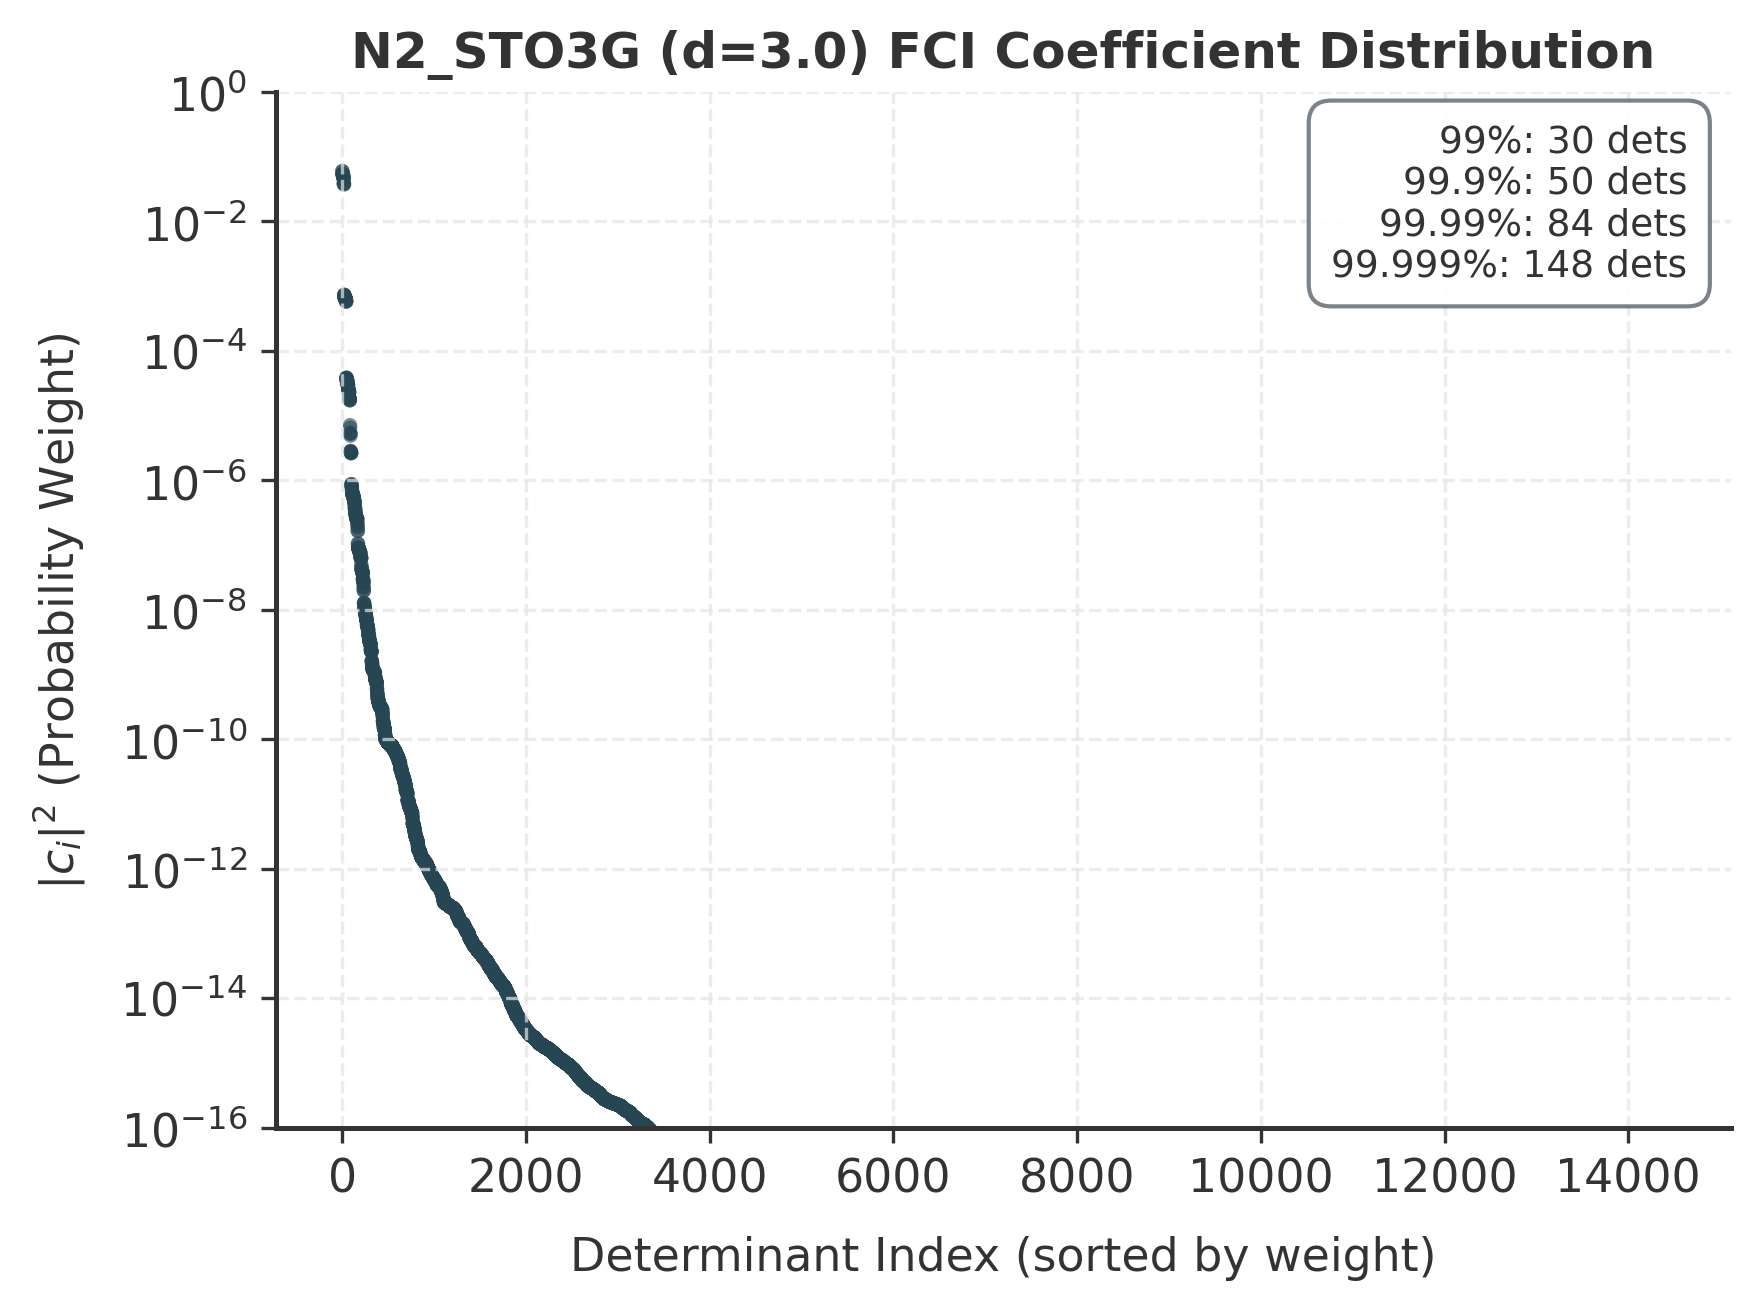

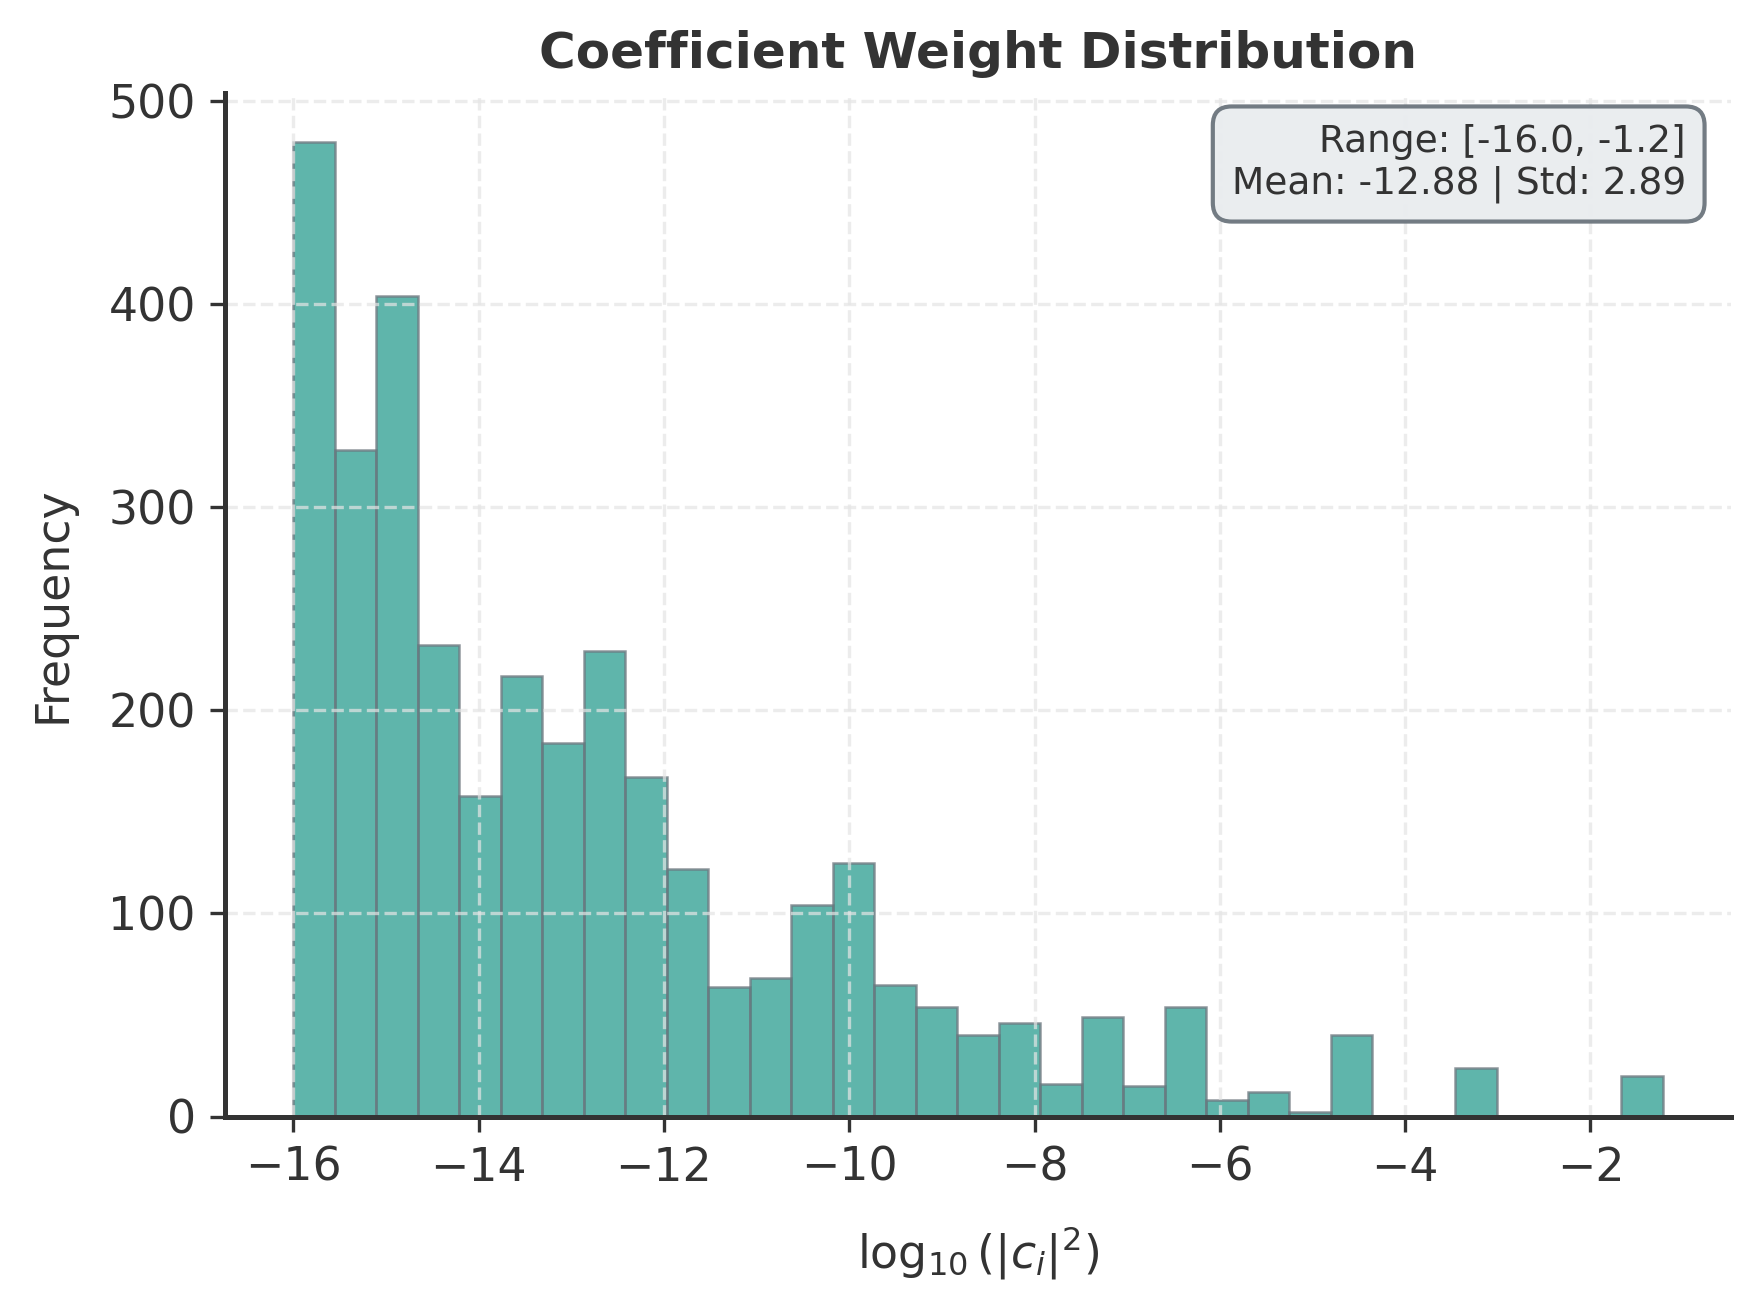

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci

def run_fci_calculation(
    atom_str: str = 'N 0 0 0; N 0 0 1.112',
    basis: str = 'sto-3g',
    charge: int = 0,
    spin: int = 0
) -> tuple[float, np.ndarray]:
    """Perform FCI calculation using PySCF."""
    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()
    
    mf = scf.RHF(mol)
    mf.kernel()
    
    cisolver = fci.FCI(mf)
    fci_energy, fci_vec = cisolver.kernel()
    
    coeffs = fci_vec.ravel()
    coeffs_normalized = coeffs / np.linalg.norm(coeffs)
    
    return fci_energy, coeffs_normalized


def plot_fci_coefficients(fci_coeffs: np.ndarray, energy: float) -> None:
    """Log-scale scatter plot of sorted coefficient weights."""
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    n_dets = len(fci_coeffs)
    det_indices = np.arange(n_dets)
    fci_weights = np.abs(fci_coeffs)**2
    
    sort_idx = np.argsort(fci_weights)[::-1]
    sorted_weights = fci_weights[sort_idx]
    
    # Main scatter plot
    ax.scatter(
        det_indices, sorted_weights,
        s=12, color=PALETTE['primary'], alpha=0.6,
        edgecolors='none'
    )
    
    # Cumulative probability thresholds
    cumsum = np.cumsum(sorted_weights)
    thresholds = [0.99, 0.999, 0.9999, 0.99999]
    threshold_labels = ['99%', '99.9%', '99.99%', '99.999%']
    
    threshold_text = []
    for thresh, label in zip(thresholds, threshold_labels):
        n_dets_needed = np.searchsorted(cumsum, thresh) + 1
        if n_dets_needed <= n_dets:
            threshold_text.append(f'{label}: {n_dets_needed:,} dets')
    
    # Add threshold info as text box
    info_text = '\n'.join(threshold_text)
    ax.text(
        0.97, 0.97, info_text,
        transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='white', 
                 edgecolor=PALETTE['bar_edge'], alpha=0.9, linewidth=1.0)
    )
    
    # Axis formatting
    ax.set_yscale('log')
    ax.set_ylim(1e-16, 1e0)
    format_axis(
        ax,
        xlabel='Determinant Index (sorted by weight)',
        ylabel=r'$|c_i|^2$ (Probability Weight)',
        grid=True,
        log_scale=True
    )
    
    ax.set_title(
        f'N2_STO3G (d=3.0) FCI Coefficient Distribution',
        fontsize=12, fontweight='bold'
    )
    
    plt.tight_layout()
    plt.show()


def plot_coefficient_histogram(fci_coeffs: np.ndarray) -> None:
    """Histogram of log₁₀(|cᵢ|²) distribution."""
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    fci_weights = np.abs(fci_coeffs)**2
    log_weights = np.log10(fci_weights[fci_weights > 1e-16])
    
    n_bins = min(60, max(30, len(log_weights) // 100))
    ax.hist(
        log_weights, bins=n_bins, 
        color=PALETTE['secondary'], alpha=0.75,
        edgecolor=PALETTE['bar_edge'], linewidth=0.6
    )
    
    format_axis(
        ax,
        xlabel=r'$\log_{10}(|c_i|^2)$',
        ylabel='Frequency',
        grid=True,
        log_scale=False
    )
    
    ax.set_title(
        'Coefficient Weight Distribution',
        fontsize=12, fontweight='bold'
    )
    
    # Summary statistics
    stats_text = (
        f'Range: [{log_weights.min():.1f}, {log_weights.max():.1f}]\n'
        f'Mean: {log_weights.mean():.2f} | Std: {log_weights.std():.2f}'
    )
    ax.text(
        0.97, 0.97, stats_text,
        transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor=PALETTE['bar_fill'], 
                 edgecolor=PALETTE['bar_edge'], alpha=0.95, linewidth=1.0)
    )
    
    plt.tight_layout()
    plt.show()


def main() -> None:
    """Execute FCI analysis pipeline with PySCF backend."""
    set_publication_style()
    
    fci_energy, fci_coeffs = run_fci_calculation(
        atom_str='N 0 0 0; N 0 0 3.0',
        basis='sto-3g',
        charge=0,
        spin=0
    )
    
    plot_fci_coefficients(fci_coeffs, fci_energy)
    plot_coefficient_histogram(fci_coeffs)


if __name__ == "__main__":
    main()